**Table of contents**<a id='toc0_'></a>    
- [Object Localization with TensorFlow](#toc1_)    
  - [Task 1: Download and Visualize Data](#toc1_1_)    
  - [Task 2: Create Examples](#toc1_2_)    
  - [Task 3: Plot Bounding Boxes](#toc1_3_)    
  - [Task 4: Data Generator](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Object Localization with TensorFlow](#toc0_)

Created for the Coursera Guided Project: [Object Localization with TensorFlow](https://www.coursera.org/projects/object-localization-tensorflow)

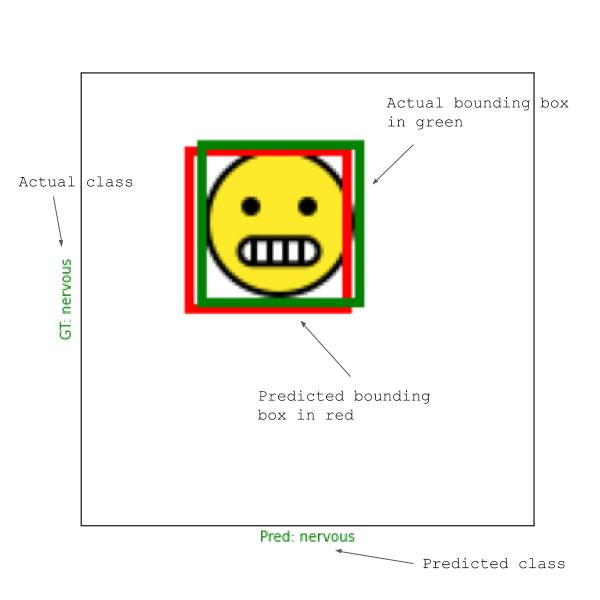

All emojis designed by [OpenMoji](https://openmoji.org/) – the open-source emoji and icon project. License: CC BY-SA 4.0

## <a id='toc1_1_'></a>[Task 1: Download and Visualize Data](#toc0_)

In [31]:
!python -m wget https://github.com/hfg-gmuend/openmoji/releases/latest/download/openmoji-72x72-color.zip
!mkdir emojis


Saved under openmoji-72x72-color (1).zip


A subdirectory or file emojis already exists.


In [32]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

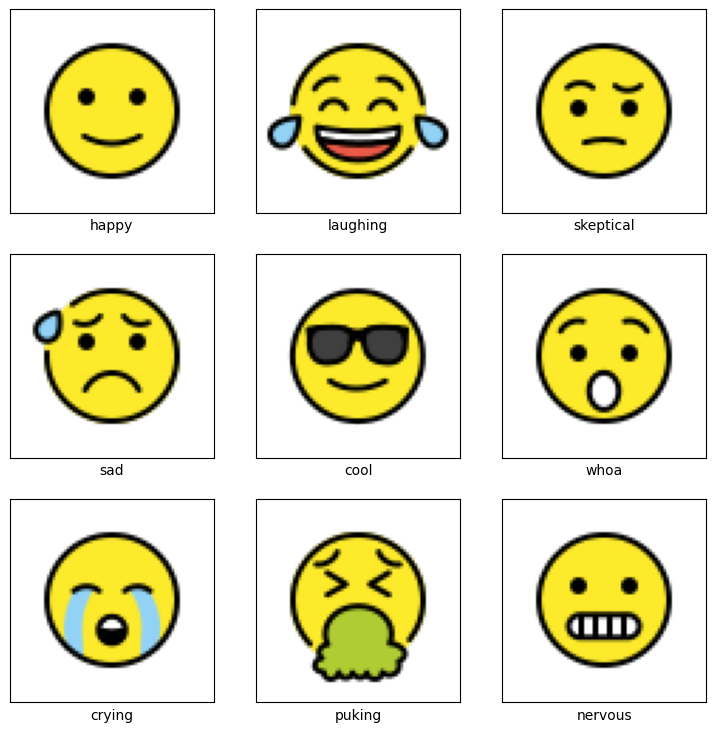

In [57]:
# This is where we are displaying the emojis that we will be using in the project

emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

## <a id='toc1_2_'></a>[Task 2: Create Examples](#toc0_)

In [58]:
for class_id, values in emojis.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [59]:
# We see now that each class has its' own file, an image, and a names
emojis

{0: {'name': 'happy',
  'file': '1F642.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 1: {'name': 'laughing',
  'file': '1F602.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 2: {'name': 'skeptical',
  'file': '1F928.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 3: {'name': 'sad',
  'file': '1F630.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 4: {'name': 'cool',
  'file': '1F60E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 5: {'name': 'whoa',
  'file': '1F62F.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 6: {'name': 'crying',
  'file': '1F62D.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 7: {'name': 'puking',
  'file': '1F92E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 8: {'name': 'nervous',
  'file': '1F62C.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>}}

In [60]:
# Randomly pick a class and synthesize an image for that class
def create_example():
    # Pick a random integer from 0 to 8
    class_id= np.random.randint(0, 9)
    
    # Create a blank image
    image = np.ones((144, 144, 3))*255
    
    # Randomly decide on where the emoji should be localized on this blank image
    row = np.random.randint(0,72)
    col = np.random.randint(0,72)
    
    # Synthesize the emoji image
    image[row: row+72, col:col+72, :] = np.array(emojis[class_id]['image'])
    
    return image.astype('uint8'), class_id, (row+10)/144, (col+10)/144

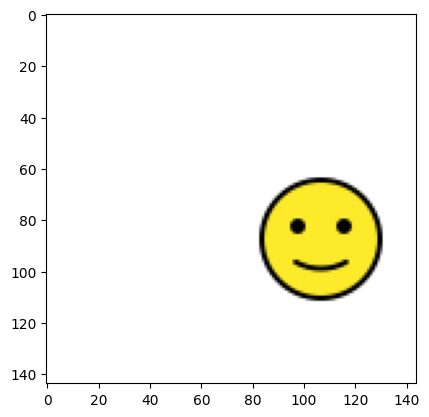

In [61]:
# Running this creates an empji that is located in a random position in the image
image, class_id, row, col = create_example()
plt.imshow(image)

## <a id='toc1_3_'></a>[Task 3: Plot Bounding Boxes](#toc0_)

In [62]:
# Let's create a class that can plot bounding boxes given a synthesized image and location
def plot_bounding_box(image, gt_coords, pred_cords=None, norm=False):
    if norm:
        image *= 255
        image = image.astype('uint8')
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    
    row, col = gt_coords
    row *= 144
    col *= 144
    draw.rectangle((col, row, col+52, row+52), outline='green', width=3)
    
    if pred_cords:
        row, col = gt_coords
        row *= 144
        col *= 144
        draw.rectangle((col, row, col+52, row+52), outline='red', width=3)
    return image

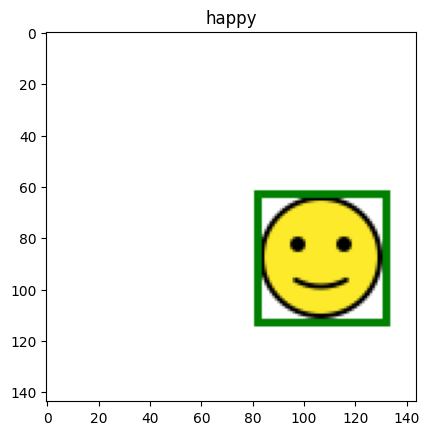

In [63]:
image = plot_bounding_box(image, gt_coords=[row, col])
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

## <a id='toc1_4_'></a>[Task 4: Data Generator](#toc0_)

In [64]:
# Now we will write a function which is going to be a generator that will generate
# an endless stream of training examples for our model.

def data_generator(batch_size = 16):
    while True:
        x_batch = np.zeros((batch_size,144, 144, 3))
        y_batch = np.zeros((batch_size,9))
        bbox_batch = np.zeros((batch_size, 2))
        
        for i in range(0, batch_size):
            image, class_id, row, col = create_example()
            x_batch[i] = image/255.
            y_batch[i, class_id] = 1.0
            bbox_batch[i] = np.array([row, col])
        yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch}

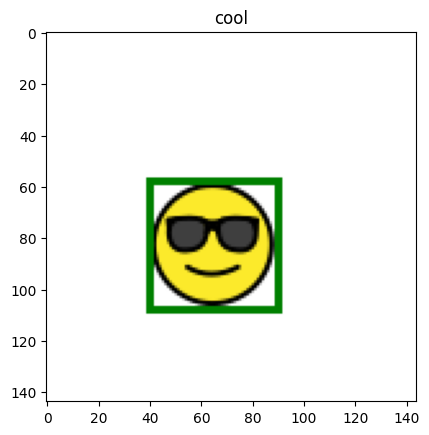

In [65]:
example, label = next(data_generator(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_bounding_box(image, coords, norm=True)
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

## Task 5: Model

In [66]:
input_ = Input(shape=(144,144,3), name='image')
x= input_

for i in range(0,5):
    n_filters = 2**(4+i)
    x= Conv2D(n_filters, 3, activation='relu')(x)
    x= BatchNormalization()(x)
    x= MaxPool2D(2)(x)
    
x= Flatten()(x)
x= Dense(256, activation='relu')(x)

class_out = Dense(9, activation='softmax', name='class_out')(x)
box_out = Dense(2, name='box_out')(x)

model= tf.keras.models.Model(input_, [class_out,box_out])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 144, 144,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 142, 142,  │        448 │ image[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 142, 142,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 71, 71,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 69, 69,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 69, 69,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 34, 34,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 5, 5, 256) │    295,168 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 256) │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 2, 2, 256) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1024)      │          0 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 659,819 (2.52 MB)

 Trainable params: 658,827 (2.51 MB)

 Non-trainable params: 992 (3.88 KB)

## Task 6: Customer Metric: IoU

In [67]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(IoU, self).__init__(**kwargs)
        
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer = 'zeros')
        self.num_ex = self.add_weight(name = 'num_ex', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        def get_box(y):
            rows, cols = y[:, 0], y[:,1]
            rows, cols = rows*144, cols*144
            y1, y2 = rows, rows+52
            x1, x2 = cols, cols+52
            return x1, y1, x2, y2
        
        def get_area(x1, y1, x2, y2):
            return tf.math.abs(x2-x1)*tf.math.abs(y2-y1)
        
        gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
        p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)
        
        i_x1 = tf.maximum(gt_x1, p_x1)
        i_y1 = tf.maximum(gt_y1, p_y1)
        i_x2 = tf.maximum(gt_x2, p_x2)
        i_y2 = tf.maximum(gt_y2, p_y2)
        
        i_area = get_area(i_x1, i_y1, i_x2, i_y2)
        u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area

        iou = tf.math.divide(i_area, u_area)
        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))
        self.iou = tf.math.divide(self.total_iou, self.num_ex)
    
    def result(self):
        return self.iou
    
    def reset_state(self):
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name= 'total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')        

## Task 7: Compile the Model

In [68]:
model.compile(
    loss={
        'class_out': 'categorical_crossentropy', 
        'box_out': 'mse'
    },
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics={
        'class_out':'accuracy',
        'box_out': IoU(name='iou')
    }
)